In [1]:
#    This file is part of DEAP.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)

import array, copy, random, time
# import logging
import numpy as np
import pandas as pd
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

# imports for the BNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

from deap import algorithms, base, creator, tools


# load min and max values of the data to denormalize prediction data
with open('maxmin.pickle', 'rb') as f:
    [max_x, min_x, max_y, min_y] = pickle.load(f)

def normalize_max_min(data, data_max, data_min):
    return (data-data_min) / (data_max-data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max-data_min) + data_min

class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x

# # load BL model BNN
# toolbox.model = torch.load('BNN_BLmodel.pt')
    
def evaluate(vars):

    # load BL model BNN
    BL_model = torch.load('BNN_BLmodel.pt')

    max_part_height = 4.2   # maximum part height mm

    # number of total layers = (maximum part height)/(height of a layer), i.e., 4.2 / (layer height)
    if vars[2] == 1:
        height = 0.42
    elif vars[2] == 2:
        height = 0.6
    elif vars[2] == 3:
        height = 0.7

    num_layers = np.int(max_part_height / height); # number of layers

    num_interfaces = 14     # number of interfaces per layer
    width = 0.8             # filament width in mm

    inp = [] # input to BNN to make predictions
    ycoord = 0.5 * height  # 0.5*height of a layer in mm
    iki_y = ycoord * 2

    # store inputs for GP(model disrepancy at each interface)
    for jj in range(1, num_layers + 1):
        for ii in range(1, num_interfaces + 1):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y ]
            inp.append([vars[0], vars[1], height, ii * width, ycoord + (jj - 1) * iki_y])

    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float32')

    # normalize data
    inp = normalize_max_min(inp, max_x, min_x)

    x_pred = torch.tensor(inp)  # convert to torch tensor

    samples = []
    noises = []
    for i in range(50):
        preds = BL_model.forward(x_pred).cpu().data.numpy()
        samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
        noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

    samples, noises = np.array(samples),  np.array(noises)
    means = (samples.mean(axis=0)).reshape(-1)

    aleatoric = (noises ** 2).mean(axis=0) ** 0.5
    epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
    total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

    # Dimensionless BL: non-dimensionalize the BL by dividing with the layer height
    dimensionless_mean_bl = means.mean()/height
    dimensionless_total_unc_bl = total_unc.mean()/height**2

    return dimensionless_mean_bl, dimensionless_total_unc_bl


IND_SIZE = 3
N_CYCLES = 1
BOUND_LOW, BOUND_UP = [217, 26, 1], [278, 44, 3]

creator.create("FitnessMin", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin, n=IND_SIZE)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_temperature", random.randint, 217, 278)
toolbox.register("attr_speed", random.randint, 26, 44)
toolbox.register("attr_layer", random.randint, 1, 3)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_temperature,toolbox.attr_speed,toolbox.attr_layer), n=N_CYCLES)


# Structure initializers
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    def decorator(func):
        def wrappper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max[i]:
                        child[i] = max[i]
                    elif child[i] < min[i]:
                        child[i] = min[i]
            return offspring
        return wrappper
    return decorator

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniform, indpb=1.0/IND_SIZE)
toolbox.register("mutate", tools.mutUniformInt, low=BOUND_LOW, up=BOUND_UP, indpb=1.0/IND_SIZE)
toolbox.register("select", tools.selNSGA2)

# Bounds on the design variables
toolbox.decorate("mate", checkBounds([217, 26, 1], [278, 44, 3]))
toolbox.decorate("mutate", checkBounds([217, 26, 1], [278, 44, 3]))

toolbox.mut_prob = 0.2  # mutation probability

def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)


# stats = tools.Statistics()
# stats.register("pop", copy.deepcopy)

# %time pop, logbook = run_ea(toolbox, stats=stats)



## Running experiments in parallel

In [2]:
experiment_name = "$n_\mathrm{{pop}}={0};\ t_\mathrm{{max}}={1}$"

In [3]:
pop_sizes = (10,50,100)       # population size
total_evals = 500          # total num. of evaluations
number_of_runs = 30

In [4]:
# replicate this toolbox instance
toolboxes=list([copy.deepcopy(toolbox) for _ in range(len(pop_sizes))])

# set the population sizes in the elements of toolboxes
for pop_size, toolbox in zip(pop_sizes, toolboxes):
    toolbox.pop_size = pop_size
    toolbox.max_gen = total_evals // pop_size
    toolbox.experiment_name = experiment_name.format(toolbox.pop_size, toolbox.max_gen)

In [5]:
%%time
results = {toolbox.experiment_name:[] for toolbox in toolboxes}

for _ in range(number_of_runs):
    for toolbox in toolboxes:
        result, _ = run_ea(toolbox)
        local_pareto_set = tools.emo.sortLogNondominated(result, len(result), first_front_only=True)
        results[toolbox.experiment_name].append(local_pareto_set)

C:\Users\berkc\Miniconda3\envs\Research_AM_2020\lib\site-packages\torch\serialization.py:420: UserWarning: Couldn't retrieve source code for container of type MC_Dropout_Model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Wall time: 3h 48min 18s


In [6]:
res = pd.DataFrame(results)
res.head()

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
0,"[[276.0, 30.0, 1.0], [245.0, 27.0, 2.0], [245....","[[275.0, 29.0, 1.0], [275.0, 29.0, 1.0], [275....","[[220.0, 27.0, 1.0], [220.0, 27.0, 1.0], [248...."
1,"[[277.0, 29.0, 1.0], [268.0, 29.0, 1.0], [248....","[[220.0, 26.0, 1.0], [220.0, 26.0, 1.0], [248....","[[219.0, 26.0, 1.0], [252.0, 26.0, 2.0], [249...."
2,"[[277.0, 28.0, 1.0], [271.0, 28.0, 1.0], [218....","[[278.0, 28.0, 1.0], [223.0, 26.0, 1.0], [257....","[[274.0, 28.0, 1.0], [274.0, 28.0, 1.0], [273...."
3,"[[259.0, 26.0, 2.0], [248.0, 26.0, 2.0], [248....","[[219.0, 26.0, 1.0], [252.0, 26.0, 2.0], [251....","[[217.0, 27.0, 1.0], [217.0, 27.0, 1.0], [253...."
4,"[[254.0, 29.0, 2.0], [244.0, 26.0, 2.0], [244....","[[277.0, 27.0, 1.0], [271.0, 30.0, 1.0], [271....","[[220.0, 27.0, 1.0], [220.0, 27.0, 1.0], [220...."


Sort the results


In [7]:
res

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
0,"[[276.0, 30.0, 1.0], [245.0, 27.0, 2.0], [245....","[[275.0, 29.0, 1.0], [275.0, 29.0, 1.0], [275....","[[220.0, 27.0, 1.0], [220.0, 27.0, 1.0], [248...."
1,"[[277.0, 29.0, 1.0], [268.0, 29.0, 1.0], [248....","[[220.0, 26.0, 1.0], [220.0, 26.0, 1.0], [248....","[[219.0, 26.0, 1.0], [252.0, 26.0, 2.0], [249...."
2,"[[277.0, 28.0, 1.0], [271.0, 28.0, 1.0], [218....","[[278.0, 28.0, 1.0], [223.0, 26.0, 1.0], [257....","[[274.0, 28.0, 1.0], [274.0, 28.0, 1.0], [273...."
3,"[[259.0, 26.0, 2.0], [248.0, 26.0, 2.0], [248....","[[219.0, 26.0, 1.0], [252.0, 26.0, 2.0], [251....","[[217.0, 27.0, 1.0], [217.0, 27.0, 1.0], [253...."
4,"[[254.0, 29.0, 2.0], [244.0, 26.0, 2.0], [244....","[[277.0, 27.0, 1.0], [271.0, 30.0, 1.0], [271....","[[220.0, 27.0, 1.0], [220.0, 27.0, 1.0], [220...."
5,"[[251.0, 27.0, 2.0], [251.0, 27.0, 2.0], [245....","[[274.0, 28.0, 1.0], [274.0, 28.0, 1.0], [269....","[[278.0, 27.0, 1.0], [275.0, 28.0, 1.0], [224...."
6,"[[222.0, 26.0, 1.0], [222.0, 27.0, 1.0], [262....","[[217.0, 27.0, 1.0], [253.0, 27.0, 2.0], [249....","[[278.0, 28.0, 1.0], [274.0, 28.0, 1.0], [269...."
7,"[[262.0, 31.0, 1.0], [262.0, 30.0, 1.0], [248....","[[217.0, 26.0, 1.0], [253.0, 26.0, 2.0], [253....","[[276.0, 29.0, 1.0], [276.0, 29.0, 1.0], [276...."
8,"[[218.0, 27.0, 1.0], [254.0, 26.0, 2.0], [252....","[[277.0, 28.0, 1.0], [277.0, 28.0, 1.0], [272....","[[272.0, 28.0, 1.0], [272.0, 28.0, 1.0], [272...."
9,"[[272.0, 28.0, 1.0], [254.0, 26.0, 2.0], [242....","[[272.0, 30.0, 1.0], [252.0, 27.0, 2.0], [252....","[[217.0, 26.0, 1.0], [257.0, 27.0, 2.0], [248...."


In [8]:
# res = res.reindex_axis([toolbox.experiment_name for toolbox in toolboxes], axis=1)

In [9]:
# res.head()

## A first glace at the results

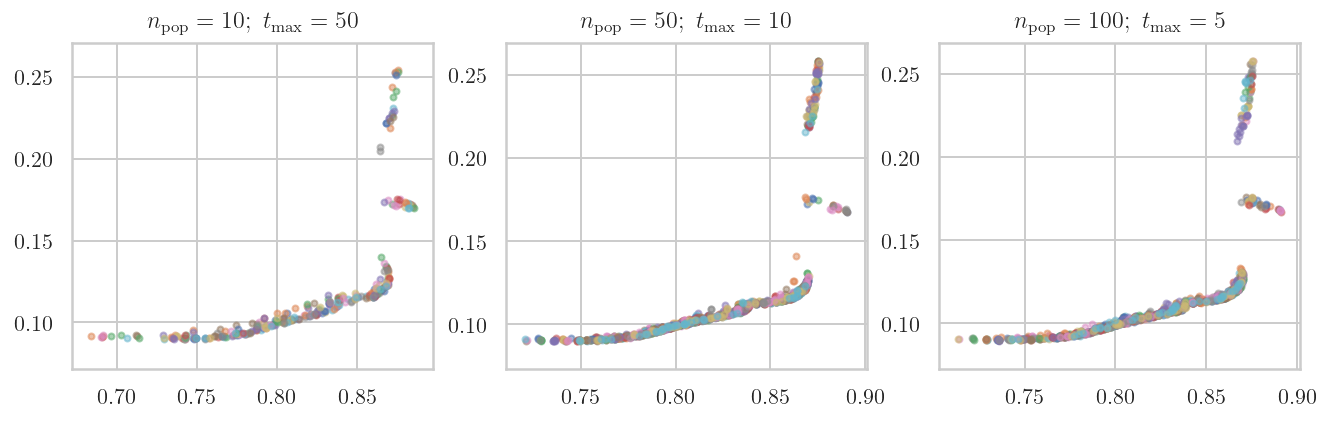

In [10]:
a = res.applymap(lambda pop: [toolbox.evaluate(ind) for ind in pop])
plt.figure(figsize=(11,3))
for i, col in enumerate(a.columns):
    plt.subplot(1, len(a.columns), i+1)
    for pop in a[col]:
        x = pd.DataFrame(data=pop)
        plt.scatter(x[0], x[1], marker='.', alpha=0.5)
    plt.title(col)   

# Calculating performance indicators
- As already mentioned, we need to evaluate the quality of the solutions produced in every execution of the algorithm.
- We will use the hypervolumne indicator for that.
- Larger hypervolume values are better.
- We already filtered each population a leave only the non-dominated individuals.

Calculating the reference point: a point that is “worst” than any other individual in every objective.

In [11]:
def calculate_reference(results, epsilon=0.1):
    alldata = np.concatenate(np.concatenate(results.values))
    obj_vals = [toolbox.evaluate(ind) for ind in alldata]
    return np.max(obj_vals, axis=0) + epsilon

In [12]:
reference = calculate_reference(res)

In [13]:
reference

array([0.99085237, 0.35843545])

Compute hypervolume of the Pareto-optimal fronts

In [14]:
import deap.benchmarks.tools as bt
hypervols = res.applymap(lambda pop: bt.hypervolume(pop, reference))
hypervols.head()

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
0,0.497831,0.497099,0.498717
1,0.495095,0.499660,0.501394
2,0.495357,0.499607,0.498836
3,0.496168,0.500579,0.500062
4,0.492525,0.498976,0.498226


In [15]:
hypervols.describe()

,$n_\mathrm{pop}=10;\ t_\mathrm{max}=50$,$n_\mathrm{pop}=50;\ t_\mathrm{max}=10$,$n_\mathrm{pop}=100;\ t_\mathrm{max}=5$
count,30.000000,30.000000,30.000000
mean,0.497481,0.499000,0.499206
std,0.001733,0.001390,0.001413
min,0.492525,0.495830,0.496171
25%,0.496387,0.498104,0.498227
50%,0.497804,0.498843,0.498791
75%,0.498532,0.499866,0.500239
max,0.500541,0.501845,0.502210


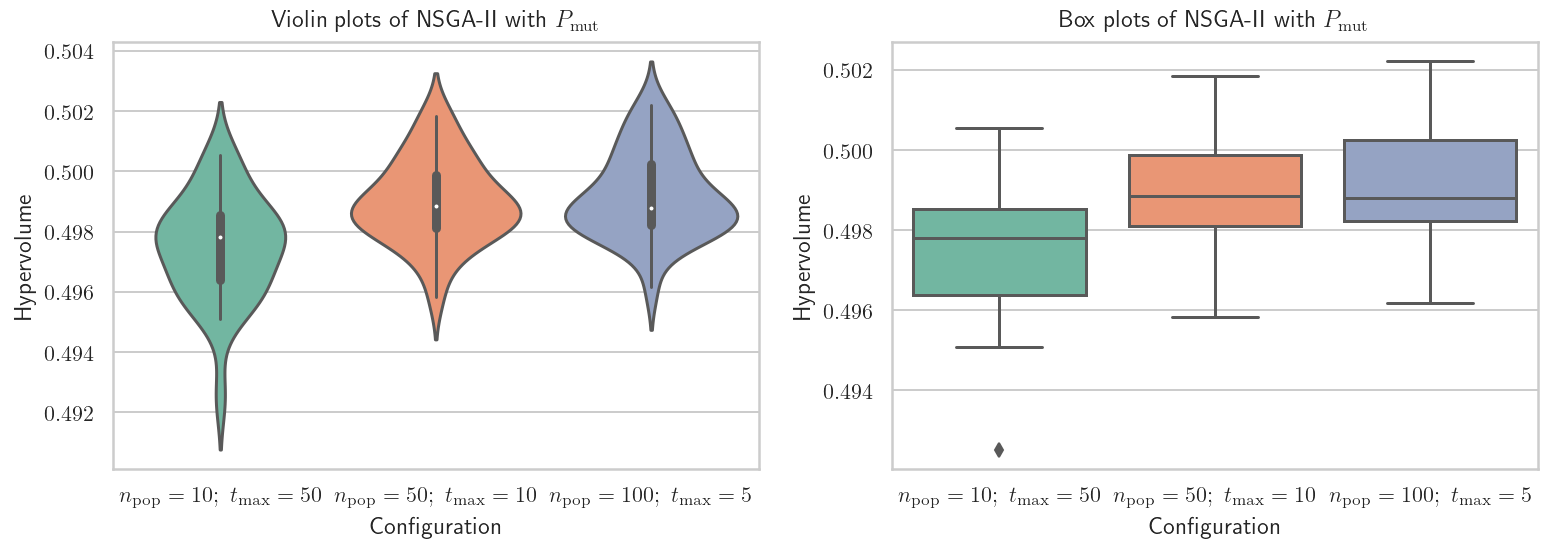

In [16]:
fig = plt.figure(figsize=(11,4))
plt.subplot(121, title='Violin plots of NSGA-II with $P_{\mathrm{mut}}$')
seaborn.violinplot(data=hypervols, palette='Set2')
plt.ylabel('Hypervolume'); plt.xlabel('Configuration')
plt.subplot(122, title='Box plots of NSGA-II with $P_{\mathrm{mut}}$')
seaborn.boxplot(data=hypervols, palette='Set2')
plt.ylabel('Hypervolume'); plt.xlabel('Configuration');
plt.tight_layout()